# Saliency Maps
https://fairyonice.github.io/Saliency-Map-with-keras-vis.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

load model

In [2]:
import keras
from vis.utils import utils
from vis.visualization import visualize_saliency

# Load the model
yaml_file = open('grid_cnn_incl_spin.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
model = keras.models.model_from_yaml(loaded_model_yaml)
# load weights into new model
model.load_weights("grid_cnn_incl_spin_weights.h5")

# Swap softmax with linear
model.layers[-1].activation = keras.activations.linear
model = utils.apply_modifications(model)

Using TensorFlow backend.
/Users/ytcheng/anaconda3/lib/python3.5/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


load data

In [8]:
X_data = np.load("X_data.npy")
y_data = np.load("y_data.npy")
X = np.zeros((X_data.shape[0], X_data.shape[1], X_data.shape[2], 1))
X[:,:,:,0] = X_data
y2d = y_data.copy()
y2d[:,0] = y_data[:,0]//20
idx = np.where(y2d[:,0]==5)[0]
y2d[idx,0] = 4
y2d[:,1] = y_data[:,1]//20
y = y2d[:,1]*5 + y2d[:,0]

ypred = model.predict_classes(X)

### build-in saliency funtion

In [4]:
# grads.shape = (100,100,3)
# some mysterious conversion, in order to show nice color plot
# grads = visualize_saliency(model, -1, filter_indices=0, seed_input=X[0])

by hand

In [5]:
import keras.backend as K

def saliency_map(model, class_idx, seed_input):
    
    ## define derivative d loss / d layer_input
    layer_input       = model.input
    ## This model must already use linear activation for the final layer
    loss              = model.layers[-1].output[...,0]
    grad_tensor       = K.gradients(loss,layer_input)[0]

    # ## create function that evaluate the gradient for a given input
    # # This function accept numpy array
    derivative_fn     = K.function([layer_input],[grad_tensor])

    # ## evaluate the derivative_fn
    grads = derivative_fn([seed_input[np.newaxis,...]])[0]
    grads = np.abs(grads).max(axis=(0,3))
    
    ## normalize to range between 0 and 1
    arr_min, arr_max  = np.min(grads), np.max(grads)
    grads = (grads - arr_min) / (arr_max - arr_min + K.epsilon())
    
    return grads

(-0.5, 99.5, 99.5, -0.5)

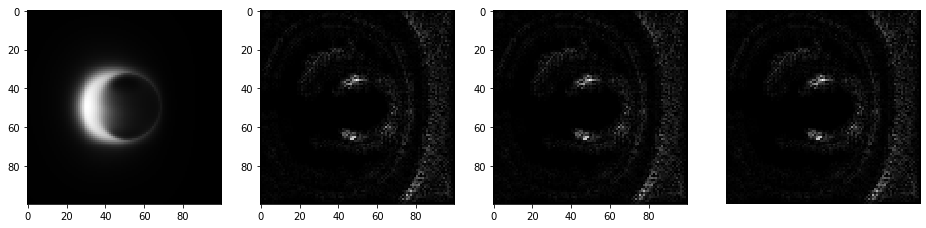

In [51]:
seed_idx = 1514

f, ax = plt.subplots(1, 4, figsize=(16,4))
ax[0].imshow(X[seed_idx].reshape([100,100]), cmap='gray')

grads = saliency_map(model, y[seed_idx], X[seed_idx])
ax[1].imshow(grads, cmap='gray')

grads = saliency_map(model, (y[seed_idx]+6)//25, X[seed_idx])
ax[2].imshow(grads, cmap='gray')

grads = saliency_map(model, (y[seed_idx]+12)//25, X[seed_idx])
ax[3].imshow(grads, cmap='gray')

plt.axis('off')

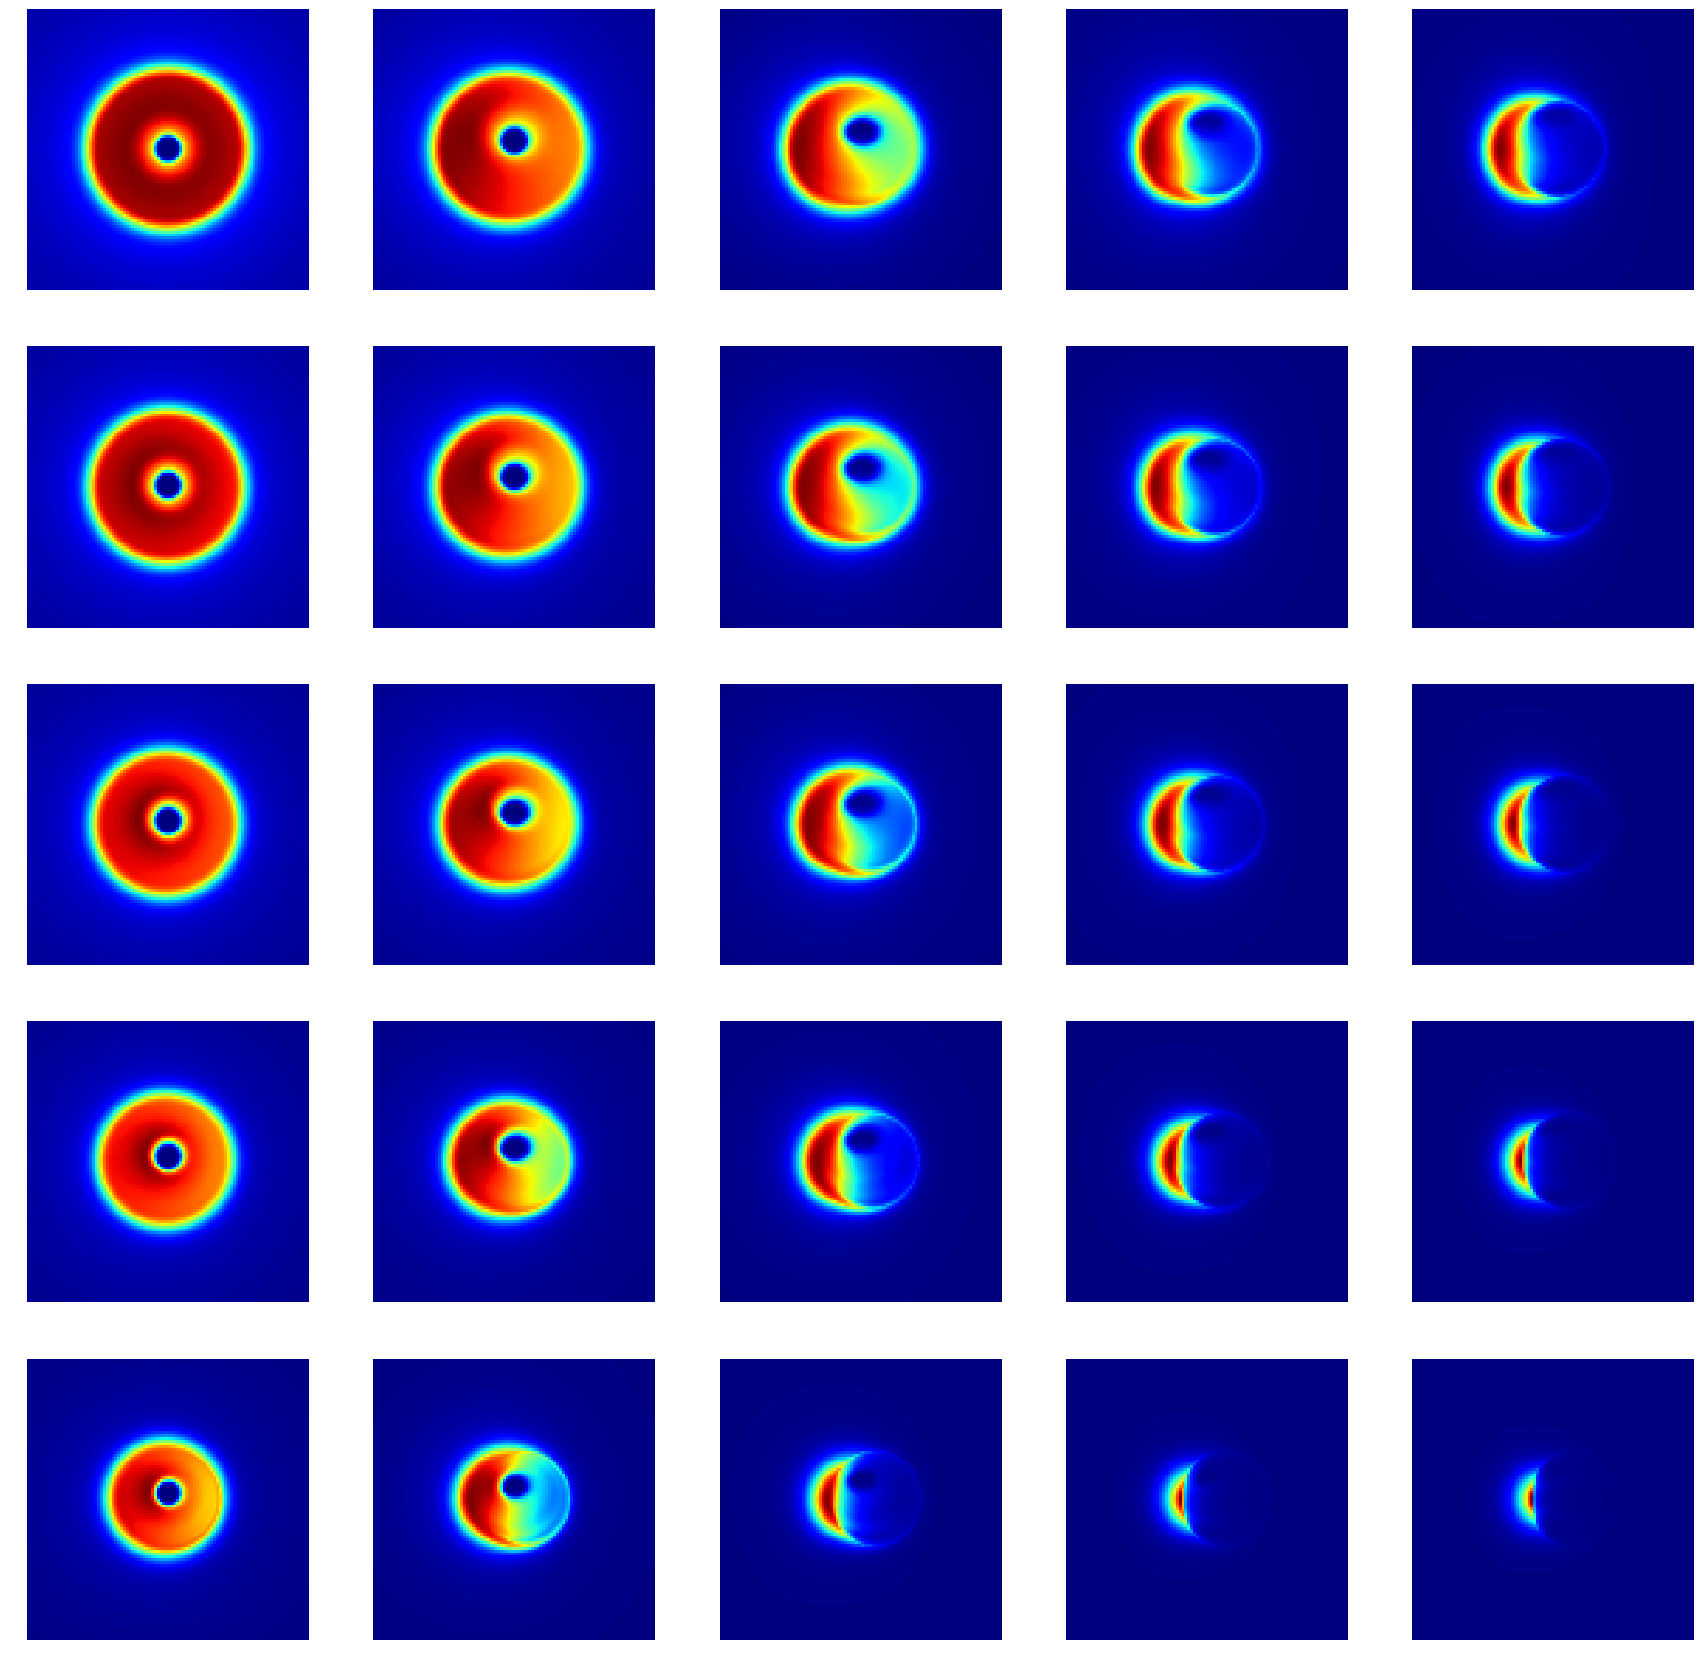

In [52]:
idxs = [int(x) for x in np.linspace(0,9089, 25)]
plt.figure(figsize=(30,30))
for i, seed_idx in enumerate(idxs):
    ax1=plt.subplot(5, 5, i+1)
    ax1.imshow(X[seed_idx].reshape(100,100), cmap='jet')
    plt.axis('off')

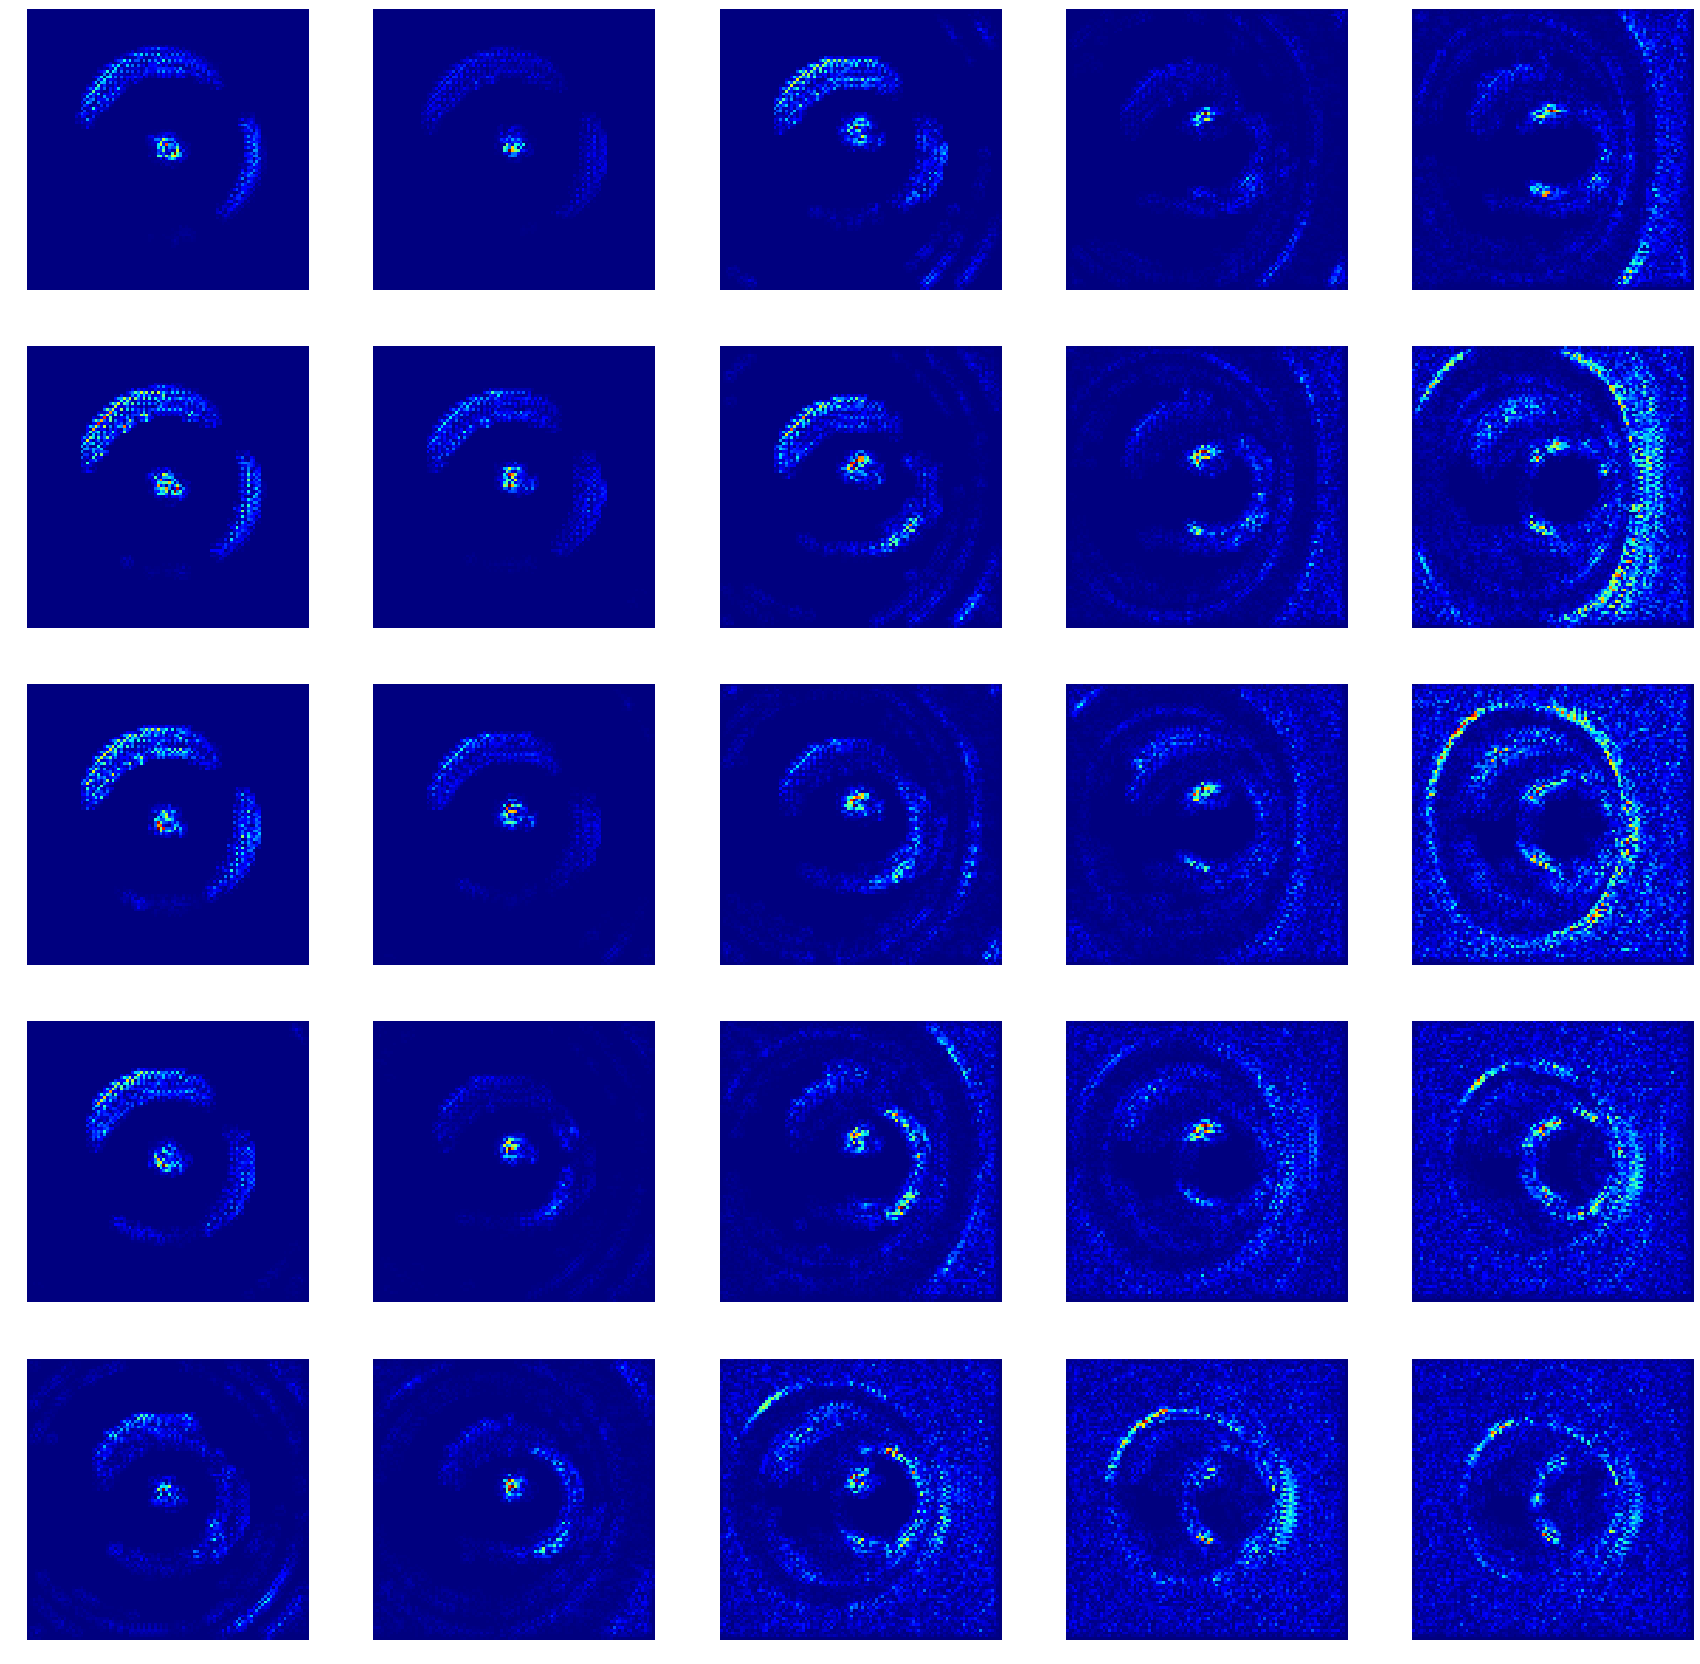

In [33]:
idxs = [int(x) for x in np.linspace(0,9089, 25)]
plt.figure(figsize=(30,30))
for i, seed_idx in enumerate(idxs):
    ax1=plt.subplot(5, 5, i+1)
    grads = saliency_map(model, y[seed_idx], X[seed_idx])
    ax1.imshow(grads, cmap='jet')
    plt.axis('off')